[[ 1.01309936e+00]
 [-5.30721621e-29]
 [ 4.28278065e-26]
 [ 1.69224708e-09]
 [-5.71803311e-29]
 [ 4.28278065e-26]]


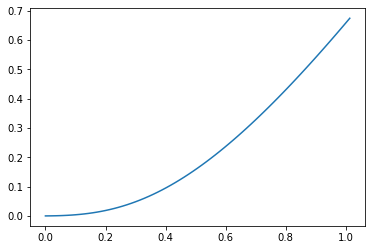

In [1]:
#Modelado inicial del problema y solucion por analisis estatico lineal.
from PySections import *
import matplotlib.pyplot as plt
estructura = Estructura()
    

h = 1.5
l = 0.05
hh = 1
concreto = Material('Concreto', 1, 0.2, 9.9*10**-6, 23.54)
seccion = Seccion('Elementos', TipoSeccion.GENERAL, [1,1], concreto)
secinft = Seccion('Elementos', TipoSeccion.GENERAL, [9*10**10,9*10**-10], concreto)

estructura.agregarNodo(x=0,y=h/2)
estructura.agregarNodo(x=l,y=0,fix=[False,False,False])
estructura.agregarNodo(x=l,y=h,fix=[False,False,False])
estructura.agregarNodo(x=hh,y=h/2)
estructura.agregarNodo(x=l+hh,y=0,fix=[False,False,False])
estructura.agregarNodo(x=l+hh,y=h,fix=[False,False,False])


estructura.agregarElemento(nodoInicial=1,nodoFinal=0,seccion=seccion,defCortante=False,tipo=Tipo.CUATRO)
estructura.agregarElemento(nodoInicial=2,nodoFinal=0,seccion=seccion,defCortante=False,tipo=Tipo.CUATRO)
estructura.agregarElemento(nodoInicial=4,nodoFinal=3,seccion=seccion,defCortante=False,tipo=Tipo.CUATRO)
estructura.agregarElemento(nodoInicial=5,nodoFinal=3,seccion=seccion,defCortante=False,tipo=Tipo.CUATRO)
estructura.agregarElemento(nodoInicial=0,nodoFinal=3,seccion=secinft,defCortante=False,tipo=Tipo.UNO)


estructura.agregarCargaNodo(nodo=0,px=1)

param = [0,0,0,0,0,0,0,0,0,0,0,0]
param[0] = 0.000001
param[1] = 0.000001
param[2] = 0.000001
param[3] = 0.0001
param[4] = 70
param[5] = 20
param[6] = 1
param[7] = 0.00005
param[8] = 0.00003
param[9] = 'bergan'
param[10] = False
param[11] = [0]
            #e1 = param[0]
            #e2 = param[1]
            #e3 = param[2]
            #dli = param[3]
            #Nd = param[4]
            #Nj = param[5]
            #gamma = param[6]
            #dlmax = param[7]
            #dlmin = param[8]
            #li = 0
            #incremento = param[9]
            
print(estructura.solucionar(verbose=True, dibujar=True, guardar=False, carpeta='',analisis='CR',param=param))
plt.plot(estructura.RECORDU,estructura.RECORDF)

In [ ]:
param = [0,0,0,0,0,0,0,0,0,0,0,0]
param[0] = 0.1 #Tol 1
param[1] = 0.0001 #Tol 2
param[2] = 0.000001 #Tol 3
param[3] = 0.1 #Delta Lambda 0
param[4] = 30 #Numero de iteraciones de Newton.
param[5] = 50 #Numero de iteraciones de carga.
param[6] = 1 #Factor gamma o alfa segun corresponda el metodo
param[7] = 0.05 #deltaLambda maximo
param[8] = 0.3 #deltaLambda minimo
param[9] = 'constante' #Metodo de calculo
param[10] = False #Usar rango de incremento definido.
param[11] = [0] #Grado de libertad a guardar (posiblemente quede inutil.)


def newton(this,param,control='carga',semilla=None):
        this.calcularFn()
        Ur = np.zeros([this.restringidos.size])
        Fn = this.Fn[np.ix_(this.libres)]
        this.RECORDU = [] #Posiblemente quitable
        this.RECORDF = [] #Posiblemente quitable
        #Inicializacion  Parámetros:
        e1 = param[0] #Tolerancia 1
        e2 = param[1] #Tolerancia 2
        e3 = param[2] #Tolerancia 3
        
        Nd = param[4] #Numero de iteraciones de newton
        Ni = param[5] + 1 #Numero de iteraciones en incrementos de carga.
        gamma = param[6] #Factor gamma o alfa
        dlmax = param[7] #deltaLambda maximo
        dlmin = param[8] ##deltaLambda minimo
        
        incremento = param[9] #Metodo de calculo
        gdl = param[11] #Grado de libertad a guardar (posiblemente quede inutil.)
        
        #Inicializacion de contenedores
        ## Lambda es el factor de carga variable en i
        dl = np.zeros([Ni,1]) #Inicializa el vector de incrementos historico, cada casilla hace referencia a una iteracion de carga
        dl[0] = param[3] #Agrega el primer incremento que se pasa por parámetro.
        ## Ul matriz de desplazamientos, cada casilla de la matriz contiene un vector de desplazamientos equivalente a la iteracion i,j
        Ul = np.zeros([Ni,1],list).tolist() #Se define como columna, ya que, no se conoce el numero de columnas que tenga  
        if not semilla == None:
            Ul[0][0] = semilla
        else:
            Ul[0][0] = np.zeros([this.libres.size]).tolist()
        #Ul[0].append(np.zeros([this.libres.size]).tolist())
        
        Kll = np.zeros([Ni,1],list).tolist()
        Pl = np.zeros([Ni,1],list).tolist()
        
        F = np.zeros([Ni,1]).tolist()
        
        l = np.zeros([Ni,1])
        
        li = 0 #Factor de incremento de carga inicial
        
        
        if control == 'carga':
            #Primera determinacion de estado
            for e in this.elementos:
                U = np.append(Ul[0][0],Ur)
                e.Ue = U[np.ix_(e.diccionario)]
            Kll[0][0] , Pl[0][0] = this.determinacionDeEstado()
            for i in range(0,Ni-1): #Iteraciones de incrementos de carga
                #Actualizar Lambda
                if i > 0:
                    if incremento == 'constante':
                        dl[i] = dl[0]
                        dlmin = dl[0]
                        dlmax = dl[0]
                    elif incremento == 'bergan':
                        num = np.dot(Fn.T,np.dot(np.linalg.inv(Kll[0][0]),Fn))
                        den = np.dot(Fn.T,np.dot(np.linalg.inv(Kll[i][-1]),Fn))
                        dl[i] = dl[i-1]*(np.dot(num,1/den))**gamma
                    elif incremento == 'numiter':
                        dl[i] = dl[0]*(Nd/(j+1))**gamma
                    else:
                        dl[i] = dl[0]
                        dlmin = dl[0]
                        dlmax = dl[0]
                dl[i] = np.max([np.max(np.array([dlmin,np.min(np.array([dlmax,dl[i]]))]))*param[10],dl[i]])
                
                #Incrementar Carga
                l[i+1]=(l[i]+dl[i])[0]
                F[i+1] = (l[i+1]*Fn)
                j = 0#Pensar en cambiar Nj, por inicio en 0, tener en cuenta aumento de carga
                Ul[i+1][j] = Ul[i][-1]
                Pl[i+1][j] = Pl[i][-1]
                Kll[i+1][j] = Kll[i][-1]
                #Newton
                R = []
                for j in range(0,Nd):
                    R.append(np.array(F[i+1])-np.array(Pl[i+1][j]))
                    norm1 =np.linalg.norm(R[j]) 
                    if norm1 < e1:
                        #OJO CON J
                        break
                    DUl = np.dot(np.linalg.inv(np.array(Kll[i+1][j])),R[j])
                    norm2 =np.linalg.norm(DUl)
                    if norm2 < e2:
                        #OJO CON J
                        break
                    if np.linalg.norm(np.dot(DUl.T,R[j]))*0.5<e3:
                        #OJO CON J
                        break
                    Ul[i+1].append(np.array(Ul[i+1][j])+DUl.T)
                    for e in this.elementos:
                        U = np.append(Ul[i+1][j+1],Ur)
                        e.Ue = U[np.ix_(e.diccionario)]
                    k,ll = this.determinacionDeEstado()
                    Kll[i+1].append(k)
                    Pl[i+1].append(ll)
        return Ul, Pl
Ul, Pl = newton(estructura,param,control='carga',semilla=None)
U = np.array(Ul)
P = np.array(Pl)
UU = []
PP = []
for i in range(1,param[5]-1):
    UU = np.append(UU,Ul[i][-1][0][0])
    PP = np.append(PP,Pl[i][-1][0][0])
fig, ax = plt.subplots(1,1,figsize=(10, 12))
ax.plot(UU,PP)
ax.grid(True)
ax.set_xlabel(r'$|U|$ [m]')
ax.set_ylabel(r'$\frac{fb}{EA}$')

In [7]:

param = [0,0,0,0,0,0,0,0,0,0,0,0]
param[0] = 0.1 #Tol 1
param[1] = 0.0001 #Tol 2
param[2] = 0.000001 #Tol 3
param[3] = 0.1 #Delta Lambda 0
param[4] = 30 #Numero de iteraciones de Newton.
param[5] = 4 #Numero de iteraciones de carga.
param[6] = 1 #Factor gamma o alfa segun corresponda el metodo
param[7] = 0.05 #deltaLambda maximo
param[8] = 0.3 #deltaLambda minimo
param[9] = 'bergan' #Metodo de calculo
param[10] = False #Usar rango de incremento definido.
param[11] = 0 #Grado de libertad a guardar (posiblemente quede inutil.)


def newton(this,param,control='carga',semilla=None):
    UU = []
    PP = []
    this.calcularFn()
    Ur = np.zeros([this.restringidos.size])
    Fn = this.Fn[np.ix_(this.libres)]
    this.RECORDU = [] #Posiblemente quitable
    this.RECORDF = [] #Posiblemente quitable
    #Inicializacion  Parámetros:
    e1 = param[0] #Tolerancia 1
    e2 = param[1] #Tolerancia 2
    e3 = param[2] #Tolerancia 3

    Nd = param[4] #Numero de iteraciones de newton
    Ni = param[5] + 1 #Numero de iteraciones en incrementos de carga.
    gamma = param[6] #Factor gamma o alfa
    dlmax = param[7] #deltaLambda maximo
    dlmin = param[8] ##deltaLambda minimo

    incremento = param[9] #Metodo de calculo
    gdl = param[11] #Grado de libertad a guardar (posiblemente quede inutil.)

    #Inicializacion de contenedores
    ## Lambda es el factor de carga variable en i
    dl = np.array([]) #Inicializa el vector de incrementos historico, cada casilla hace referencia a una iteracion de carga
    dl = np.append(dl,param[3]) #Agrega el primer incremento que se pasa por parámetro.
    ## Ul matriz de desplazamientos, cada casilla de la matriz contiene un vector de desplazamientos equivalente a la iteracion i,j
     #Se define como columna, ya que, no se conoce el numero de columnas que tenga  
    if not semilla == None:
        semilla= semilla
    else:
        semilla = np.zeros([this.libres.size])
    Ul = np.array([semilla])
    Kll = np.array([],np.ndarray)
    Pl = np.array([],np.ndarray)
    F = np.array([],np.ndarray)
    l = np.array([])
    l = np.append(l,0.0)
    li = 0 #Factor de incremento de carga inicial
    if control == 'carga':
        #Primera determinacion de estado
        for e in this.elementos:
            U = np.append(Ul[0],Ur)
            e.Ue = U[np.ix_(e.diccionario)]
        Kllp , Plp = this.determinacionDeEstado()
        Kll = np.append(Kll,[0])
        Kll[-1] = Kllp
        Pl = np.append(Pl,[0])
        Pl[-1] = Plp
        for i in range(0,Ni-1): #Iteraciones de incrementos de carga
            #Actualizar Lambda
            if i > 0:
                if incremento == 'constante':
                    dl = np.append(dl,dl[0])
                    dlmin = dl[0]
                    dlmax = dl[0]
                elif incremento == 'bergan':
                    num = np.dot(Fn.T,np.dot(np.linalg.inv(Kll[0]),Fn))
                    den = np.dot(Fn.T,np.dot(np.linalg.inv(Kll[-1]),Fn))
                    dl = np.append(dl,dl[0]*(np.dot(num,1/den))**gamma)
                elif incremento == 'numiter':
                    dl = np.append(dl,dl[i-1]*(Nd/(j+1))**gamma)
                else:
                    dl = np.append(dl,dl[0])
                    dlmin = dl[0]
                    dlmax = dl[0]
            dl[i] = np.max([np.max(np.array([dlmin,np.min(np.array([dlmax,dl[i]]))]))*param[10],dl[i]])

            #Incrementar Carga
            l = np.append(l,(l[i]+dl[i]))
            F = np.append(F,[0])
            F[-1] = l[i+1]*Fn
            if i ==5:
                break
            j = 0#Pensar en cambiar Nj, por inicio en 0, tener en cuenta aumento de carga
            UlJ = np.copy(Ul[-1])
            PlJ = np.copy(Pl[-1])
            KllJ = np.copy(Kll[-1])
            #Newton
            for j in range(0,Nd):
                R = F[-1]-PlJ
                if j == 3:
                    break
                norm1 = np.linalg.norm(R) 
                if norm1 < e1:
                    break
                DUl = np.dot(np.linalg.inv(KllJ),R)
                norm2 =np.linalg.norm(DUl)
                if norm2 < e2:
                    break
                norm3 = np.linalg.norm(np.dot(DUl.T,R))*0.5
                if norm3<e3:
                    break
                UlJ = (UlJ+DUl.T)[0]
                for e in this.elementos:
                    U = np.append(UlJ,Ur)
                    e.Ue = U[np.ix_(e.diccionario)]
                KllJ,PlJ = this.determinacionDeEstado()
            UU = np.append(UU, UlJ[0])
            PP = np.append(PP, PlJ[0])
            Ul = np.vstack([Ul,UlJ])
            Pl = np.vstack([[Pl[0]],[PlJ]])
            Kll = np.vstack([[Kll[0]],[KllJ]])
    return UU, PP
U,P = newton(estructura,param,control='carga',semilla=None)
ax.plot(UU,PP)
ax.grid(True)
ax.set_xlabel(r'$|U|$ [m]')
ax.set_ylabel(r'$\frac{q_1}{EA}$')

Text(25.525000000000006, 0.5, '$\\frac{q_1}{EA}$')

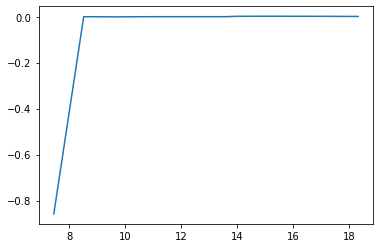

In [4]:
#Modelado inicial del problema y solucion por analisis estatico lineal.
from PySections import *
import matplotlib.pyplot as plt
estructura = Estructura()
    

h = 125
l = 175
dx = l/9
dy = 125/175
areaCable = 0.987/10000
nCables = 28
p = -nCables*areaCable*78.5/2*l/9
acero = Material('STEEL', 200000000, 0.2, 9.9*10**-6, 78.5)
cable = Seccion('Elementos', TipoSeccion.GENERAL, [areaCable*nCables,1], acero)

estructura.agregarNodo(x=0,y=0,fix=[False,False,False])
estructura.agregarNodo(x=dx,y=dx*dy)
estructura.agregarNodo(x=2*dx,y=2*dx*dy)
estructura.agregarNodo(x=3*dx,y=3*dx*dy)
estructura.agregarNodo(x=4*dx,y=4*dx*dy)
estructura.agregarNodo(x=5*dx,y=5*dx*dy)
estructura.agregarNodo(x=6*dx,y=6*dx*dy)
estructura.agregarNodo(x=7*dx,y=7*dx*dy)
estructura.agregarNodo(x=8*dx,y=8*dx*dy)
estructura.agregarNodo(x=9*dx,y=9*dx*dy,fix=[False,False,False])


estructura.agregarElemento(nodoInicial=0,nodoFinal=1,seccion=seccion,defCortante=False,tipo=Tipo.DOS)
estructura.agregarElemento(nodoInicial=1,nodoFinal=2,seccion=seccion,defCortante=False,tipo=Tipo.DOS)
estructura.agregarElemento(nodoInicial=2,nodoFinal=3,seccion=seccion,defCortante=False,tipo=Tipo.DOS)
estructura.agregarElemento(nodoInicial=3,nodoFinal=4,seccion=seccion,defCortante=False,tipo=Tipo.DOS)
estructura.agregarElemento(nodoInicial=4,nodoFinal=5,seccion=seccion,defCortante=False,tipo=Tipo.DOS)
estructura.agregarElemento(nodoInicial=5,nodoFinal=6,seccion=seccion,defCortante=False,tipo=Tipo.DOS)
estructura.agregarElemento(nodoInicial=6,nodoFinal=7,seccion=seccion,defCortante=False,tipo=Tipo.DOS)
estructura.agregarElemento(nodoInicial=7,nodoFinal=8,seccion=seccion,defCortante=False,tipo=Tipo.DOS)
estructura.agregarElemento(nodoInicial=8,nodoFinal=9,seccion=seccion,defCortante=False,tipo=Tipo.DOS)


estructura.agregarCargaNodo(nodo=0,py=p)
estructura.agregarCargaNodo(nodo=1,py=p*2)
estructura.agregarCargaNodo(nodo=2,py=p*2)
estructura.agregarCargaNodo(nodo=3,py=p*2)
estructura.agregarCargaNodo(nodo=4,py=p*2)
estructura.agregarCargaNodo(nodo=5,py=p*2)
estructura.agregarCargaNodo(nodo=6,py=p*2)
estructura.agregarCargaNodo(nodo=7,py=p*2)
estructura.agregarCargaNodo(nodo=8,py=p*2)
estructura.agregarCargaNodo(nodo=9,py=p)


param = [0,0,0,0,0,0,0,0,0,0,0,0]
param[0] = 0.1 #Tol 1
param[1] = 0.0001 #Tol 2
param[2] = 0.000001 #Tol 3
param[3] = 0.1 #Delta Lambda 0
param[4] = 40 #Numero de iteraciones de Newton. (ESTO NO DEBERIA PORQUE SER ASI!!!!!!)
param[5] = 10 #Numero de iteraciones de carga.
param[6] = 1 #Factor gamma o alfa segun corresponda el metodo
param[7] = 0.05 #deltaLambda maximo
param[8] = 0.3 #deltaLambda minimo
param[9] = 'constante' #Metodo de calculo
param[10] = False #Usar rango de incremento definido.
param[11] = [15]

#estructura.solucionar(True,True)
estructura.solucionar(verbose=True, dibujar=True, guardar=False, carpeta='',analisis='CR',param=param)
plt.plot(estructura.RECORDU,estructura.RECORDF)

In [5]:
param = [0,0,0,0,0,0,0,0,0,0,0,0]
param[0] = 0.00001
param[1] = 0.000001
param[2] = 0.000001
param[3] = 0.001
param[4] = 70
param[5] = 100
param[6] = 1
param[7] = 0.00005
param[8] = 0.00003
param[9] = 'constante'
param[10] = False
param[11] = [0]

def newton2(this,param,control='des',semilla=None):
        this.calcularFn()
        Ur = np.zeros([this.restringidos.size])
        Fn = this.Fn[np.ix_(this.libres)]
        this.RECORDU = [] #Posiblemente quitable
        this.RECORDF = [] #Posiblemente quitable
        #Inicializacion  Parámetros:
        e1 = param[0] #Tolerancia 1
        e2 = param[1] #Tolerancia 2
        e3 = param[2] #Tolerancia 3
        
        Nd = param[4] #Numero de iteraciones de newton
        Ni = param[5] + 1 #Numero de iteraciones en incrementos de carga.
        gamma = param[6] #Factor gamma o alfa
        dlmax = param[7] #deltaLambda maximo
        dlmin = param[8] ##deltaLambda minimo
        
        incremento = param[9] #Metodo de calculo
        gdl = param[11] #Grado de libertad a guardar (posiblemente quede inutil.)
        
        #Inicializacion de contenedores
        ## Lambda es el factor de carga variable en i
        dl = np.zeros([Ni,1]) #Inicializa el vector de incrementos historico, cada casilla hace referencia a una iteracion de carga
        dl[0] = param[3]
        du = np.zeros([Ni,1]) #Inicializa el vector de incrementos historico, cada casilla hace referencia a una iteracion de carga
        du[0] = param[3] #Agrega el primer incremento que se pasa por parámetro.
        ## Ul matriz de desplazamientos, cada casilla de la matriz contiene un vector de desplazamientos equivalente a la iteracion i,j
        Ul = np.zeros([Ni,1],list).tolist() #Se define como columna, ya que, no se conoce el numero de columnas que tenga  
        if not semilla == None:
            Ul[0][0] = semilla
        else:
            Ul[0][0] = np.zeros([this.libres.size]).tolist()
        #Ul[0].append(np.zeros([this.libres.size]).tolist())
        
        Kll = np.zeros([Ni,1],list).tolist()
        Pl = np.zeros([Ni,1],list).tolist()
        
        F = np.zeros([Ni,1]).tolist()
        
        l = np.zeros([Ni,1])
        DUF = np.zeros([Ni,1]).tolist()
        DUL = np.zeros([Ni,1]).tolist()
        
        li = 0 #Factor de incremento de carga inicial
        
        
        if control == 'des':
            #Primera determinacion de estado
            g = np.zeros([this.libres.size])
            g[np.ix_(param[11])] = 1
            for e in this.elementos:
                U = np.append(Ul[0][0],Ur)
                e.Ue = U[np.ix_(e.diccionario)]
            Kll[0][0] , Pl[0][0] = this.determinacionDeEstado()
            F[0] = Fn
            for i in range(0,Ni-1): #Iteraciones de incrementos de carga
                #Actualizar Lambda
                if i > 0:
                    if incremento == 'numiter':
                        du[i] = du[i-1]*(Nd/(j+1))**gamma
                    else:
                        du[i] = du[0]
                        dlmin = du[0]
                        dlmax = du[0]
                du[i] = np.max([np.max(np.array([dlmin,np.min(np.array([dlmax,du[i]]))]))*param[10],du[i]])
                
                #Incrementar Carga
                something = np.dot(np.linalg.inv(np.array(Kll[i][-1])),Fn)
                DUF[i] = (something)
                dufg = np.dot((g),np.array(DUF[i]))
                dl[i] = np.dot(du[i],1/dufg)
                l[i+1]=(l[i]+dl[i])[0]
                treintaycicno = dl[i][0]*DUF[i]
                DUL[i] = treintaycicno
                j=0
                Ul[i+1][j] = Ul[i][-1] + DUL[i].T
                
                Pl[i+1][j] = Pl[i][-1]
                Kll[i+1][j] = Kll[i][-1]
                
                ldj = l[i+1]
                dlj = dl[i]
                DUFJ = DUF[i]
                Fj = F[i]
                #Newton
                R = []
                for j in range(0,Nd):
                    Fj = ldj*Fn
                    R.append(np.array(Fj)-np.array(Pl[i+1][j]))
                    norm1 =np.linalg.norm(R[j]) 
                    if norm1 < e1:
                        #OJO CON J
                        break
                    DUR = np.dot(np.linalg.inv(np.array(Kll[i+1][j])),R[j])
                    if j>0:
                        DUFJ = np.dot(np.linalg.inv(np.array(Kll[i+1][j])),Fn)
                    Numerador =np.dot(g,DUR)
                    denominador = np.dot(g,DUFJ)
                    dlj = -Numerador/denominador
                    ldj = ldj+dlj
                    DUl = DUR+np.dot(dlj[0],DUFJ)
                    Ul[i+1].append(np.array(Ul[i+1][j])+DUl.T)
                    for e in this.elementos:
                        U = np.append(Ul[i+1][j+1],Ur)
                        e.Ue = U[np.ix_(e.diccionario)]
                    k,ll = this.determinacionDeEstado()
                    Kll[i+1].append(k)
                    Pl[i+1].append(ll)
                F[i+1] = Fj
        return Ul, Pl
Ul, Pl = newton2(estructura,param,control='carga',semilla=None)
U = np.array(Ul)
P = np.array(Pl)
UU = []
PP = []
for i in range(1,param[5]-1):
    UU = np.append(UU,Ul[i][-1][0][0])
    PP = np.append(PP,Pl[i][-1][0][0])
plt.plot(UU,PP)

TypeError: 'int' object is not subscriptable